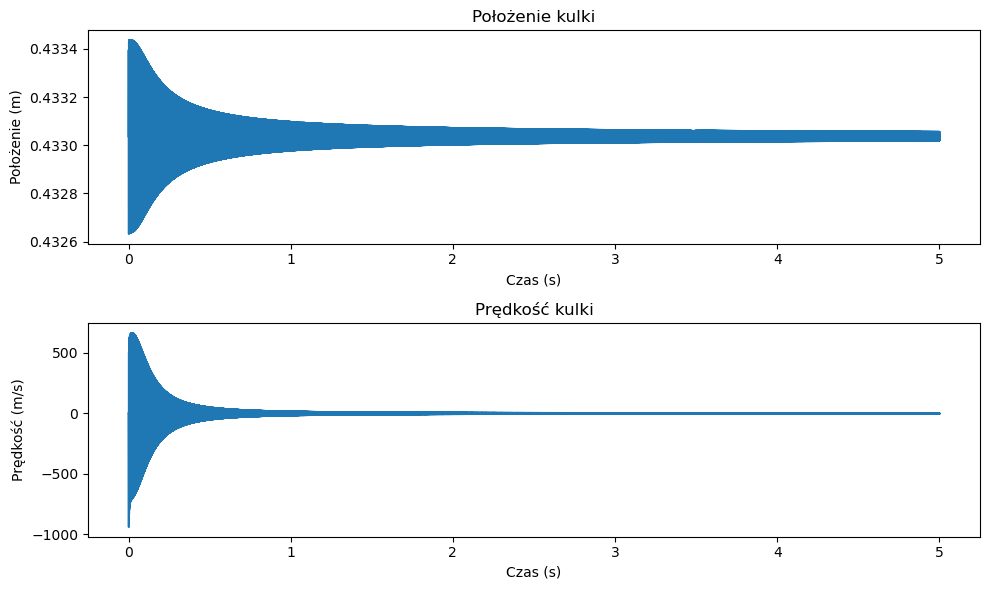

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numba

# Definicje stałych
frequency = 40000  # Hz
wavelength = 343 / frequency  # m
amplitude = 400  # Zwiększona amplituda
rho_air = 1.225  # kg/m^3
c_air = 343  # m/s
mu_air = 1.82e-5  # Pa*s
radius = 0.01  # m
rho_particle = 30  # kg/m^3
c_particle = 900  # m/s
mass = (4/3) * np.pi * radius**3 * rho_particle  # kg
diameter = 2 * radius

# Współczynniki potencjału Gorkova
K1 = (1 / (4 * np.pi * c_air**2 * rho_air)) * (1 - (rho_air / rho_particle))
K2 = (1 / (8 * np.pi * c_air**2 * rho_air)) * ((rho_particle - rho_air) / (2 * rho_particle + rho_air))

# Dokładniejsze modelowanie pola akustycznego
@numba.njit
def acoustic_field_amplitude(z, transducer_distance):
    k = 2 * np.pi / wavelength
    distance_factor = np.sin(k * z) * np.exp(-z / transducer_distance)  # Model dyfrakcji i nieliniowości
    amplitude_effective = amplitude * distance_factor
    return amplitude_effective

# Uwzględnienie harmonicznych w funkcji potencjału Gorkova
@numba.njit
def gorkov_potential(z, transducer_distance):
    amplitude_effective = acoustic_field_amplitude(z, transducer_distance)
    k = 2 * np.pi / wavelength
    harmonic_term = np.cos(4 * k * z)  # Uwzględnienie drugiej harmonicznej
    return (4 / 3) * np.pi * radius**3 * (K1 * amplitude_effective**2 * (np.cos(2 * k * z) - 1 + harmonic_term) + 3 * K2 * amplitude_effective**2 * np.cos(2 * k * z))

# Równanie ruchu kulki z uwzględnieniem nieliniowych efektów akustycznych
@numba.njit
def ball_motion(state, dt, transducer_distance):
    z, v = state
    k = 2 * np.pi / wavelength
    amplitude_effective = acoustic_field_amplitude(z, transducer_distance)
    d_gorkov_potential_dz = -(8 / 3) * np.pi * radius**3 * K1 * amplitude_effective**2 * k * np.sin(2 * k * z) * (1 + np.cos(k * (transducer_distance - 2 * z)))
    acoustic_force_gradient = d_gorkov_potential_dz
    Re = (rho_air * v * diameter) / mu_air
    
    if Re < 1:
        drag_force = -6 * np.pi * mu_air * radius * v  # Stokes' Drag
    else:
        Cd = 24 / Re + 6 / (1 + np.sqrt(Re)) + 0.4  # Współczynniki oporu dla różnych Re
        drag_force = -0.5 * Cd * rho_air * np.pi * radius**2 * v**2
    
    # Dodanie siły strumieniowania akustycznego
    streaming_force = 0.5 * amplitude_effective**2 * rho_air * c_air * np.sin(k * z)
    
    # Dodanie tłumienia kawitacyjnego
    cavitation_damping = -0.1 * v if amplitude_effective > 1e6 else 0  # Przykładowe tłumienie kawitacyjne
    
    gravity_force = -mass * 9.81
    total_force = acoustic_force_gradient + drag_force + streaming_force + cavitation_damping + gravity_force
    dv_dt = total_force / mass
    dz_dt = v
    return [z + dz_dt * dt, v + dv_dt * dt]

# Warunki początkowe i symulacja
z0 = 50.5 * wavelength
v0 = 0  # m/s
state0 = [z0, v0]
transducer_distance = 100 * wavelength
t = np.linspace(0, 5, 1000000)
solution = odeint(ball_motion, state0, t, args=(transducer_distance,))

# Wykresy
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, solution[:, 0])
plt.title('Położenie kulki')
plt.xlabel('Czas (s)')
plt.ylabel('Położenie (m)')

plt.subplot(2, 1, 2)
plt.plot(t, solution[:, 1])
plt.title('Prędkość kulki')
plt.xlabel('Czas (s)')
plt.ylabel('Prędkość (m/s)')

plt.tight_layout()
plt.show()
